In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import time

tempoInicial = time.time()

In [2]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psix(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

def psixt(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    Pxt = N(n)*Hn(x)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

In [3]:
def CrankNicolson(M, O = 0, L = 1, T = 0.5):
    N = 500 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    #Obtenção da matriz psi (Ela acumulará para o psi futuro)
    ps = np.zeros((M, N))
    psi_c = np.zeros((M, N))

    #Condição inicial
    ps[:,0] = 0.80 * psix(0, xs) + 0.60 * psix(1, xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
    psi_c = ps.astype(complex)
    #For para o acúmulo de resultados
    for k in range(1,N):
        b = np.matmul(matrizB, np.array(psi_c[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi_c[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
        #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    return psi_c

In [4]:
def multMatrizes(M, us, O = -5, L = 5, T = 10):
    N = 500 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)
    
    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    #V = us #V(x,u(t))
    V = 1/2*m*w**2*xs**2+us

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()

    return np.matmul(np.linalg.inv(matrizA), matrizB)

In [5]:
# Gradiente e função objetivo

def ExactSolution(M, T = 5, L = 5):
    N = 100

    xs = np.linspace(-5, L, M)
    
    psiExato = np.zeros((M, M)).astype(complex)
    r=0
    for i in np.arange(-5, 5, 0.02):
        for j in np.arange(0, 10, 0.02):
            psiExato[r][int(j*50)] = 1/np.sqrt(2)*psixt(0,i,j)+1/np.sqrt(2)*psixt(1,i,j)
        r+=1
    return psiExato

def Objetivo(x, y, psi, psiExato):
    A = np.zeros((500,500))
    B = np.zeros((500,500))
    A = multMatrizes(M = 500, us = x[0])
    B = multMatrizes(M = 500, us = x[1])
    return ((np.linalg.norm(np.array(psiExato[0:500, y])-np.array(psi)))**2+
            (np.linalg.norm(np.array(psiExato[0:500, y+1])-np.array(np.matmul(A,psi))))**2+
            (np.linalg.norm(np.array(psiExato[0:500, y+2])-np.array(np.matmul(np.matmul(B,A),psi))))**2)

In [6]:
import random

psi = np.zeros((500,500))
psi_f = np.zeros((500,500))
psi_g = psi_f.astype(complex)
psi = CrankNicolson(M = 500, O = -5, L = 5, T = 10)
psiExato = ExactSolution(M = 500)

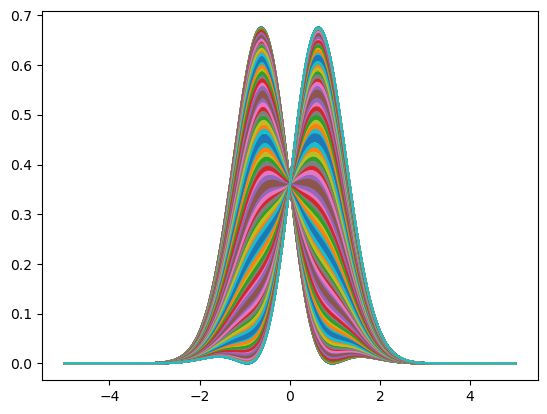

In [7]:
xs = np.linspace(-5,5,500)
plt.plot(xs, np.absolute(psi[0:500,0:500])**2)

[-3.417076400611656, 2.9343995338070936]
Iteração: 1
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 141703.17403303116
       x: [-1.259e+03  8.018e+00]
     nit: 8
     jac: [ 0.000e+00  0.000e+00]
    nfev: 126
    njev: 42
---------------
[-1259.2832103943617, -2.7314830495241127]
Iteração: 2
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 127644.96173628364
       x: [ 8.007e+00  7.858e+00]
     nit: 17
     jac: [-1.953e-03  2.930e-03]
    nfev: 255
    njev: 81
---------------
[8.007415308472055, 3.241441218176231]
Iteração: 3
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 127179.13490211853
       x: [ 7.868e+00  7.742e+00]
     nit: 6
     jac: [ 0.000e+00  0.000e+00]
    nfev: 78
    njev: 26
---------------
[7.867549194171462, -1.4120735655456818]
Iteração: 4
 message: Optimization terminated successfully.
 success: True
  status: 0
     fu

Iteração: 29
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 106294.85356939962
       x: [ 1.192e+01 -9.996e+00]
     nit: 5
     jac: [ 0.000e+00  0.000e+00]
    nfev: 36
    njev: 12
---------------
[11.916974896057987, -3.0693177641877023]
Iteração: 30
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 106373.39641094446
       x: [-1.001e+01  6.841e+00]
     nit: 6
     jac: [ 4.883e-03  1.953e-03]
    nfev: 138
    njev: 42
---------------
[-10.008633176393175, 4.5935276284089674]
Iteração: 31
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 122207.52268395227
       x: [ 6.844e+00  6.869e+00]
     nit: 10
     jac: [ 1.953e-03 -9.766e-04]
    nfev: 87
    njev: 29
---------------
[6.844441920334931, 1.8802183165898967]
Iteração: 32
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  stat

Iteração: 57
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 113161.17269824742
       x: [ 2.449e+01 -2.993e-01]
     nit: 1
     jac: [ 0.000e+00  9.766e-04]
    nfev: 134
    njev: 41
---------------
[24.486339392869883, 3.7526049742355667]
Iteração: 58
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 113707.2200240744
       x: [ 1.305e+01 -7.771e+00]
     nit: 4
     jac: [ 3.906e-03 -1.953e-03]
    nfev: 203
    njev: 64
---------------
[13.054728624480235, 3.750595556110669]
Iteração: 59
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 114069.62272242867
       x: [-7.768e+00  1.058e+01]
     nit: 7
     jac: [ 0.000e+00  9.766e-04]
    nfev: 105
    njev: 35
---------------
[-7.767517956750524, -1.948947972636872]
Iteração: 60
 message: Desired error not necessarily achieved due to precision loss.

Iteração: 85
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 136492.84617267543
       x: [ 1.353e+01  1.293e+01]
     nit: 10
     jac: [ 0.000e+00  0.000e+00]
    nfev: 117
    njev: 39
---------------
[13.530796829176207, 1.6967140738113624]
Iteração: 86
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 136016.4809659004
       x: [ 1.293e+01  1.240e+01]
     nit: 7
     jac: [ 0.000e+00  0.000e+00]
    nfev: 66
    njev: 22
---------------
[12.931599729131541, 4.781320010305837]
Iteração: 87
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 135520.13360415632
       x: [ 1.239e+01  1.191e+01]
     nit: 6
     jac: [ 7.812e-03  3.906e-03]
    nfev: 63
    njev: 18
---------------
[12.39303500425015, 1.0355593865129933]
Iteração: 88
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 135007.66637190527
       x: [ 1.189e+

Iteração: 113
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 123459.75945891914
       x: [ 7.086e+00  7.024e+00]
     nit: 11
     jac: [ 0.000e+00  0.000e+00]
    nfev: 96
    njev: 32
---------------
[7.086246882133846, -4.969010644130691]
Iteração: 114
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 123122.40001307114
       x: [ 7.025e+00  1.891e+01]
     nit: 11
     jac: [ 0.000e+00  0.000e+00]
    nfev: 194
    njev: 64
---------------
[7.0254879280605955, 4.210004694900073]
Iteração: 115
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 106921.50658780319
       x: [ 1.892e+01  4.208e+00]
     nit: 2
     jac: [ 2.930e-03 -1.953e-03]
    nfev: 129
    njev: 39
---------------
[18.922976970909, -4.545467889526419]
Iteração: 116
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 106701.2278932542
       x: [ 1.27

Iteração: 141
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 124722.96881827756
       x: [ 7.238e+00  7.296e+00]
     nit: 10
     jac: [ 0.000e+00  1.953e-03]
    nfev: 141
    njev: 47
---------------
[7.238463543344254, 1.450970525977624]
Iteração: 142
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 125088.16144323624
       x: [ 7.296e+00  7.376e+00]
     nit: 10
     jac: [ 9.766e-04  9.766e-04]
    nfev: 227
    njev: 72
---------------
[7.2955263698266295, -3.5777578230182385]
Iteração: 143
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 125471.95286807154
       x: [ 7.373e+00  7.455e+00]
     nit: 9
     jac: [ 0.000e+00  0.000e+00]
    nfev: 138
    njev: 46
---------------
[7.373438375344451, 0.24987868770587163]
Iteração: 144
 message: Desired error not necessarily achieved due to precision loss.
 success: False
 

Iteração: 169
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 138110.43484796654
       x: [ 1.538e+01  1.597e+01]
     nit: 12
     jac: [-3.906e-03 -7.812e-03]
    nfev: 173
    njev: 54
---------------
[15.382190595983367, 2.5782657973599923]
Iteração: 170
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 138418.90700110313
       x: [ 1.598e+01  1.656e+01]
     nit: 7
     jac: [ 5.859e-03  1.953e-03]
    nfev: 218
    njev: 69
---------------
[15.984418490575814, 0.0652500191882659]
Iteração: 171
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 138679.27561464533
       x: [ 1.655e+01  1.709e+01]
     nit: 7
     jac: [ 0.000e+00  0.000e+00]
    nfev: 69
    njev: 23
---------------
[16.554492211575504, -1.1430971300908133]
Iteração: 172
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1388

Iteração: 198
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 129635.70610310373
       x: [ 8.639e+00  8.451e+00]
     nit: 9
     jac: [ 0.000e+00  0.000e+00]
    nfev: 78
    njev: 26
---------------
[8.638591845763505, -1.087649543177717]
Iteração: 199
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 129121.1183092016
       x: [ 8.445e+00  8.292e+00]
     nit: 7
     jac: [ 9.766e-04  9.766e-04]
    nfev: 245
    njev: 78
---------------
[8.445485241772083, 0.4420464287955994]
Iteração: 200
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 128617.0176653704
       x: [ 8.267e+00  8.151e+00]
     nit: 6
     jac: [ 1.953e-03  0.000e+00]
    nfev: 117
    njev: 39
---------------
[8.267075911670888, -1.9814925999790276]
Iteração: 201
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  statu

Iteração: 226
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 121794.63349360981
       x: [ 6.804e+00  6.802e+00]
     nit: 7
     jac: [ 0.000e+00  0.000e+00]
    nfev: 42
    njev: 14
---------------
[6.804205853170558, 2.2999023963424428]
Iteração: 227
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 121830.15849472556
       x: [ 6.802e+00  6.809e+00]
     nit: 10
     jac: [ 0.000e+00  0.000e+00]
    nfev: 87
    njev: 29
---------------
[6.801970169740623, -4.983509296599501]
Iteração: 228
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 121889.31089411181
       x: [ 6.813e+00  6.820e+00]
     nit: 3
     jac: [-9.766e-04 -9.766e-04]
    nfev: 146
    njev: 45
---------------
[6.813344851113326, -2.5826009233757152]
Iteração: 229
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 121972.00663463246
       x: [ 6.

Iteração: 254
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 130691.06504275888
       x: [ 8.863e+00  9.059e+00]
     nit: 4
     jac: [ 1.270e-02  5.859e-03]
    nfev: 174
    njev: 54
---------------
[8.862689686793793, 2.778872417081044]
Iteração: 255
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 131228.91234181618
       x: [ 9.063e+00  9.317e+00]
     nit: 8
     jac: [ 0.000e+00  0.000e+00]
    nfev: 89
    njev: 29
---------------
[9.062756716241694, -0.9948160179704377]
Iteração: 256
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 131771.36784901546
       x: [ 9.322e+00  9.588e+00]
     nit: 4
     jac: [ 0.000e+00  0.000e+00]
    nfev: 36
    njev: 12
---------------
[9.32186172493453, -3.078683602953882]
Iteração: 257
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 132316.6148

Iteração: 283
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 137368.5645098881
       x: [ 1.477e+01  1.412e+01]
     nit: 5
     jac: [ 1.172e-02  3.906e-03]
    nfev: 243
    njev: 77
---------------
[14.766540280937802, 2.258696729617549]
Iteração: 284
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 136945.03936019388
       x: [ 1.414e+01  1.351e+01]
     nit: 6
     jac: [ 0.000e+00  0.000e+00]
    nfev: 48
    njev: 16
---------------
[14.14253905027823, -0.5969610497058744]
Iteração: 285
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 136492.84619602683
       x: [ 1.350e+01  1.296e+01]
     nit: 10
     jac: [ 0.000e+00  0.000e+00]
    nfev: 120
    njev: 40
---------------
[13.502678882273205, 2.5835703541717203]
Iteração: 286
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 136016.

Iteração: 311
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 124050.7837637029
       x: [ 7.168e+00  7.115e+00]
     nit: 16
     jac: [ 0.000e+00  0.000e+00]
    nfev: 126
    njev: 42
---------------
[7.168083980062727, 2.8769042796137505]
Iteração: 312
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 123744.88030786594
       x: [ 7.118e+00  7.071e+00]
     nit: 9
     jac: [ 0.000e+00  0.000e+00]
    nfev: 61
    njev: 19
---------------
[7.117773951166497, -3.418221257744676]
Iteração: 313
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 123459.75942545864
       x: [ 7.072e+00  7.027e+00]
     nit: 10
     jac: [-9.766e-04 -9.766e-04]
    nfev: 162
    njev: 50
---------------
[7.0718922230625685, 4.385325492246663]
Iteração: 314
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 123195.8

Iteração: 340
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 124376.98707207071
       x: [ 7.155e+00  7.234e+00]
     nit: 12
     jac: [ 0.000e+00  0.000e+00]
    nfev: 87
    njev: 29
---------------
[7.154946777165052, -1.0009439061265213]
Iteração: 341
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 124722.96881637693
       x: [ 7.235e+00  7.299e+00]
     nit: 10
     jac: [ 0.000e+00  0.000e+00]
    nfev: 111
    njev: 37
---------------
[7.2346808029532506, 0.40953721766164275]
Iteração: 342
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 125088.1614481151
       x: [ 7.302e+00  7.365e+00]
     nit: 10
     jac: [ 0.000e+00  0.000e+00]
    nfev: 111
    njev: 37
---------------
[7.3022358268430185, 2.4980090619972177]
Iteração: 343
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 125471.9528682323
       x: [ 7.372e+00  7.454e+00]
 

Iteração: 369
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 138110.43484247423
       x: [ 1.536e+01  1.601e+01]
     nit: 7
     jac: [ 0.000e+00  0.000e+00]
    nfev: 63
    njev: 21
---------------
[15.3569401915454, -4.065905998709113]
Iteração: 370
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 138418.90710282486
       x: [ 1.604e+01  1.652e+01]
     nit: 11
     jac: [ 0.000e+00  0.000e+00]
    nfev: 96
    njev: 32
---------------
[16.0423067171018, -4.490605175115975]
Iteração: 371
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 138679.27567322215
       x: [ 1.653e+01  1.706e+01]
     nit: 6
     jac: [ 1.953e-03 -3.906e-03]
    nfev: 111
    njev: 37
---------------
[16.53398662874397, -4.480042368625533]
Iteração: 372
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 138887.09873362957
       x: [ 1.711

Iteração: 398
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 129635.70611446648
       x: [ 8.629e+00  8.458e+00]
     nit: 13
     jac: [-1.953e-03 -1.953e-03]
    nfev: 222
    njev: 70
---------------
[8.628889935900137, -4.668923714666447]
Iteração: 399
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 129121.1183074742
       x: [ 8.456e+00  8.275e+00]
     nit: 6
     jac: [ 1.953e-03  3.906e-03]
    nfev: 200
    njev: 63
---------------
[8.455991396306365, -1.7371506554056038]
Iteração: 400
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 128617.01759998366
       x: [ 8.281e+00  8.129e+00]
     nit: 10
     jac: [ 0.000e+00  0.000e+00]
    nfev: 99
    njev: 33
---------------
[8.281031938495998, 0.6447456044597004]
Iteração: 401
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 128124.

Iteração: 427
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 121830.15849771354
       x: [ 6.801e+00  6.806e+00]
     nit: 9
     jac: [-3.906e-03 -5.859e-03]
    nfev: 81
    njev: 27
---------------
[6.801359133646937, 4.314935476841859]
Iteração: 428
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 121889.31088824855
       x: [ 6.811e+00  6.819e+00]
     nit: 11
     jac: [ 1.953e-03  0.000e+00]
    nfev: 123
    njev: 41
---------------
[6.811247884734889, -0.8470399870528436]
Iteração: 429
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 121972.0066702033
       x: [ 6.817e+00  6.821e+00]
     nit: 8
     jac: [-2.930e-03 -2.930e-03]
    nfev: 92
    njev: 27
---------------
[6.817082615240882, 1.7011010372595692]
Iteração: 430
 message: Optimization terminated successfully.
 success: True
  statu

Iteração: 455
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 131228.91235564277
       x: [ 9.081e+00  9.303e+00]
     nit: 12
     jac: [ 0.000e+00  0.000e+00]
    nfev: 99
    njev: 33
---------------
[9.080781365203476, -1.9750606400650996]
Iteração: 456
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 131771.36786870362
       x: [ 9.317e+00  9.573e+00]
     nit: 7
     jac: [ 0.000e+00  0.000e+00]
    nfev: 51
    njev: 17
---------------
[9.317068036670609, -2.3788071816278245]
Iteração: 457
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 132316.6148038471
       x: [ 9.587e+00  9.889e+00]
     nit: 14
     jac: [ 0.000e+00  0.000e+00]
    nfev: 126
    njev: 42
---------------
[9.586998103365554, -3.3535107948579688]
Iteração: 458
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 132862.66212886063
       x: [ 

Iteração: 483
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 137368.56450882278
       x: [ 1.478e+01  1.412e+01]
     nit: 5
     jac: [-1.953e-03 -1.953e-03]
    nfev: 155
    njev: 48
---------------
[14.775539260450651, -0.6951676103014126]
Iteração: 484
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 136945.03935594147
       x: [ 1.412e+01  1.352e+01]
     nit: 16
     jac: [ 3.906e-03  0.000e+00]
    nfev: 373
    njev: 121
---------------
[14.124570846436924, 2.1834013071100884]
Iteração: 485
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 136492.84628132542
       x: [ 1.355e+01  1.289e+01]
     nit: 7
     jac: [ 0.000e+00  0.000e+00]
    nfev: 57
    njev: 19
---------------
[13.547266024520987, -3.000449649697452]
Iteração: 486
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 136

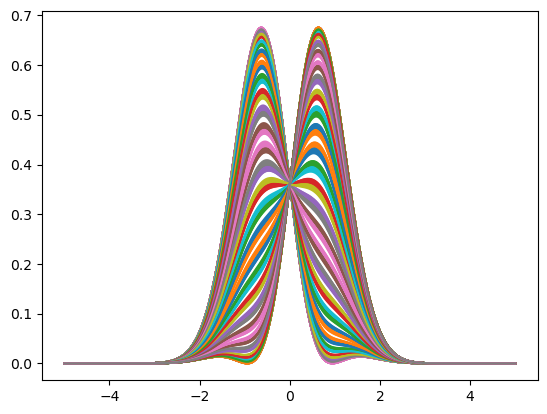

In [8]:
u1 = []
u2 = []
vetor = []
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
tempo = 0
xs = np.linspace(-5,5,500)
minimo = np.zeros((1, 500)).astype(complex)

while tempo < 498:
    print(u1)
    psi_g[0:500, tempo] = psi[0:500, tempo]
    plt.plot(xs, np.absolute(psi[0:500, tempo])**2)
    u2 = optimize.minimize(Objetivo, u1, args=(tempo, psi, psiExato), method='CG')
    print(f"Iteração: {tempo+1}")
    print(u2)
    print("---------------")
    minimo[0][tempo] = (u2.x[0])
    D = multMatrizes(M = 500, us = u2.x[0])
    psi = np.matmul(D, psi)
    tempo += 1
    u1 = []
    u1.append(u2.x[0])
    u1.append(random.uniform(-5, 5))

tempoFinal = time.time() - tempoInicial
print(tempoFinal)

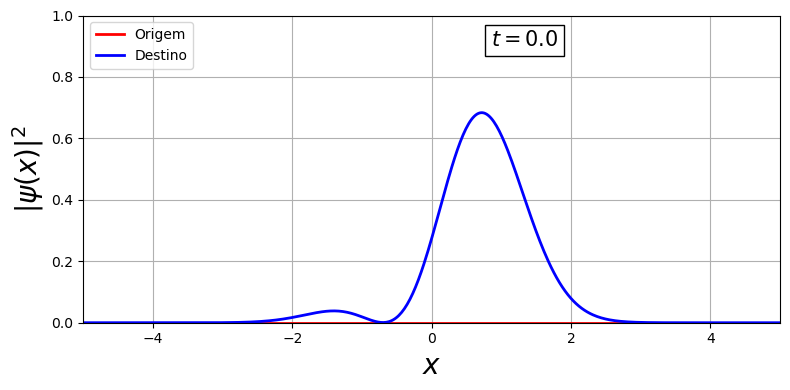

In [9]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

def animate(i):
    xs = np.linspace(-5,5,500)
    ln1.set_data(xs, np.absolute(psi_g[0:500,i-1])**2)
    ln2.set_data(xs, np.absolute(psiExato[0:500,i-1])**2)
    time_text.set_text('$t=$'+'{:.1f}'.format(i/100))
    
fig, ax = plt.subplots(1, 1,figsize=(8,4))
ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Origem')
ln2, = plt.plot([], [], 'b-', lw=2, markersize=8, label='Destino')
time_text = ax.text(0.85, 0.9, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(0, 1)
ax.set_xlim(-5,5)
title = ax.set_title('Resposta analítica')
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=500, interval=200)
ani.save('500x500.gif',writer='pillow',fps=10,dpi=100)

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_8992\1060170165.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  minn[0][i] = minimo[0][i+49]


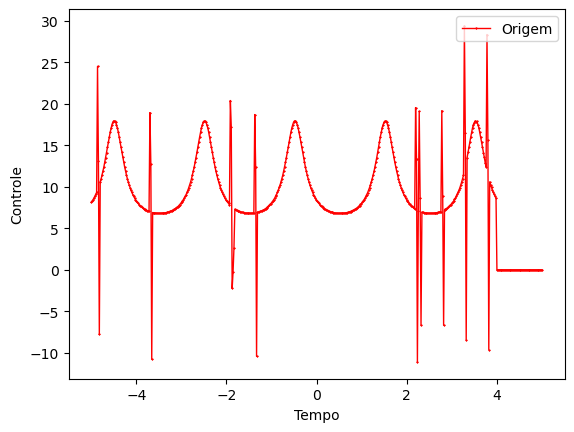

In [12]:
t = np.linspace(-5, 5, 500)

minn = np.zeros((1, 500))

for i in range(0, 450):
    minn[0][i] = minimo[0][i+49]

plt.ylabel('Controle') 
plt.xlabel('Tempo') 
plt.plot(t, minn[0], color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.legend(loc='upper right')
plt.savefig('500.png', format='png')